In [ ]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    learning_rate,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
    filename_prefix,
    poster_shape, # (height, width)
    num_unfreeze_layers,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models

    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

    self.filename_prefix = filename_prefix

    self.poster_shape = poster_shape

    self.num_unfreeze_layers = num_unfreeze_layers

cfg = Config(
    num_classes=5,
    num_epochs=100, # Due to dropout
    batch_size = 32,
    learning_rate = 1e-3,
    early_stopping_patience = 5, # Due to dropout
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
    filename_prefix = '6_bor_poster_postreleased_efficientnet/',
    poster_shape = (268, 182),
    num_unfreeze_layers = 50
)

# Обработка данных

## Очистка

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse
from pathlib import Path

df = pd.read_csv('./movie_dataset.csv', index_col=0)

to_drop = [
    'id',
    'tagline',
    'overview',
    'vote_count',
    'original_title',
    'title',
    'spoken_languages',
    'original_language',
]
df = df.drop(columns=to_drop)

df['budget'] = df['budget'].replace({0: np.nan})
df['revenue'] = df['revenue'].replace({0: np.nan})
df['runtime'] = df['runtime'].replace({0: np.nan})

df.dropna(inplace=True)
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

df['production_company'] = df.apply(lambda x: x['production_companies'][0], axis=1)
df['production_country'] = df.apply(lambda x: x['production_countries'][0], axis=1)
df = df.drop(columns=['production_companies', 'production_countries'], axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df[df['actors'].map(len) == 3]
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

posters = Path('./posters')
imdb_ids = [x.name[:-len('.jpg')] for x in posters.glob('*.jpg')]
df = df[df['imdb_id'].isin(imdb_ids)]
df['poster'] = df.apply(lambda x: f'./posters/{x["imdb_id"]}.jpg', axis=1)

df = df.drop(columns=['imdb_id'], axis=1)


## Формирование целевой переменной

In [ ]:
def get_class(row):
  R = row['revenue']
  if R <= 5000000:
    return 0
  elif 5000000 < R <= 25000000:
    return 1
  elif 25000000 < R <= 50000000:
    return 2
  elif 50000000 < R <= 125000000:
    return 3
  elif 125000000 < R:
    return 4
  return np.nan

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'], axis=1)

## Извлечение и преобразование признаков

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        # Жанры
        self.genres_mlb = MultiLabelBinarizer().fit(X['genres'].values)
        # Продюсерская компания
        self.production_company_encoder = LabelEncoder().fit(X['production_company'].values)
        # Страна производства
        self.production_country_encoder = LabelEncoder().fit(X['production_country'].values)
        # Дистрибьютор
        self.domestic_distributor_encoder = LabelEncoder().fit(X['domestic_distributor'].values)
        # Режиссер
        self.director_encoder = LabelEncoder().fit(X['director'].values)
        # Актеры
        unique_actors = pd.concat([df['actor_1'], df['actor_2'], df['actor_3']]).unique()
        self.actor_encoder = LabelEncoder().fit(unique_actors)
        # Месяц выхода
        self.release_month_encoder = OneHotEncoder(sparse_output=False).fit(X['release_month'].values.reshape(-1, 1))
        # Возрастной рейтинг
        self.mpaa_encoder = OneHotEncoder(sparse_output=False).fit(X['mpaa'].values.reshape(-1, 1))
        # Бюджет
        self.budget_scaler = StandardScaler().fit(X['budget'].values.reshape(-1, 1))
        # Длительность
        self.runtime_scaler = StandardScaler().fit(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        self.vote_average_scaler = StandardScaler().fit(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        self.domestic_opening_scaler = StandardScaler().fit(X['domestic_opening'].values.reshape(-1, 1))

        self.columns_order = [
            'actor_1', 'actor_2', 'actor_3', 'director', 'production_company', 'production_country', 'domestic_distributor',
            'runtime', 'budget', 'vote_average', 'domestic_opening', 'poster',
            'genre_action', 'genre_adventure', 'genre_animation',
            'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
            'genre_family', 'genre_fantasy', 'genre_foreign', 'genre_history',
            'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller', 'genre_war', 'genre_western',
            'release_month_1', 'release_month_2', 'release_month_3',
            'release_month_4', 'release_month_5', 'release_month_6',
            'release_month_7', 'release_month_8', 'release_month_9',
            'release_month_10', 'release_month_11', 'release_month_12',
            'mpaa_G', 'mpaa_NC-17', 'mpaa_PG', 'mpaa_PG-13', 'mpaa_R'
        ]

        return self

    def transform(self, X):
        # Жанры
        classes = [f'genre_{x.replace(" ", "_").lower()}' for x in self.genres_mlb.classes_]
        transformed_genres = self.genres_mlb.transform(X['genres'].values)
        X = X.join(pd.DataFrame(transformed_genres.astype(bool), X.index, classes))
        X = X.drop(columns=['genres'], axis=1)
        # Продюсерская компания
        X['production_company'] = self.production_company_encoder.transform(X['production_company'].values)
        # Страна производства
        X['production_country'] = self.production_country_encoder.transform(X['production_country'].values)
        # Дистрибьютор
        X['domestic_distributor'] = self.domestic_distributor_encoder.transform(X['domestic_distributor'].values)
        # Режиссер
        X['director'] = self.director_encoder.transform(X['director'].values)
        # Актеры
        for i in range(1, 4):
            X[f'actor_{i}'] = self.actor_encoder.transform(X[f'actor_{i}'].values)
        # Месяц выхода
        classes = [f'release_month_{x}' for x in self.release_month_encoder.categories_[0]]
        transfored_release_month = self.release_month_encoder.transform(X['release_month'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_release_month.astype(bool), X.index, classes))
        X = X.drop(columns=['release_month'], axis=1)
        # Возрастной рейтинг
        classes = [('mpaa_' + x.upper()) for x in self.mpaa_encoder.categories_[0]]
        transfored_mpaa = self.mpaa_encoder.transform(X['mpaa'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_mpaa.astype(bool), X.index, classes))
        X = X.drop(columns=['mpaa'], axis=1)
        # Бюджет
        X['budget'] = self.budget_scaler.transform(X['budget'].values.reshape(-1, 1))
        # Длительность
        X['runtime'] = self.runtime_scaler.transform(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        X['vote_average'] = self.vote_average_scaler.transform(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        X['domestic_opening'] = self.domestic_opening_scaler.transform(X['domestic_opening'].values.reshape(-1, 1))

        X = X[self.columns_order]

        return X

preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', PreprocessingTransformer()),
])

X = df.drop(columns=['target'], axis=1)
y = df['target'].to_numpy()

# Fit and evaluate the model
X = preprocess_pipeline.fit_transform(X, y)

### Сохранение преобразования признаков

In [ ]:
import dill

with open(f'{cfg.filename_prefix}pipeline.pkl', 'wb') as f:
    dill.dump(preprocess_pipeline, f, protocol=5)

# Построение и обучение моделей

## Вспомогательная функциональность

Опишем фукнцию, которая будет оценивать получившуюся модель

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

results = {}

# Функция для оценки полученной модели
def inspect_model(model, test_generator, y, model_name, history=None):
  predictions = model.predict(test_generator)
  # real_classes = y.argmax(axis=1)
  real_classes = y
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  real_classes = real_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  predicted_classes = predicted_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)

  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=m)
  disp.plot(cmap=plt.cm.gray_r)
  plt.show()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }


Также опишем класс, который будет отвечать за генерацию батчей с изображениями

In [ ]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import cv2

def load_image(path, size):
    img = image.load_img(path)
    img = image.img_to_array(img)
    img = cv2.resize(img, size)
    return img

class PosterGenerator(Sequence):
    def __init__(
        self,
        posters,
        labels,
        batch_size,
        dim,
        shuffle,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.posters = posters
        self.labels = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.posters))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.posters) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        height, width = self.dim
        X = np.empty((self.batch_size, height, width, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            X[i,] = load_image(
                path=self.posters[idx],
                size=(width, height),
            )
            y[i] = self.labels[idx]

        return X, y

Опишем класс для генерации данных для таблично-постерной модели

In [ ]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import cv2

class TabularPosterGenerator(Sequence):
    def __init__(
        self,
        tabular,
        posters,
        labels,
        batch_size,
        dim,
        shuffle,
        shuffle_posters=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.tabular = tabular
        self.posters = posters
        self.labels = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_posters = shuffle_posters

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.posters))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        if self.shuffle_posters == True:
            np.random.shuffle(self.posters)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.posters) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Xt = np.empty((self.batch_size, self.tabular.shape[1]), dtype=np.float32)
        height, width = self.dim
        Xp = np.empty((self.batch_size, height, width, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            Xt[i,] = self.tabular[idx]
            Xp[i,] = load_image(
                path=self.posters[idx],
                size=(width, height),
            )
            y[i] = self.labels[idx]

        return (Xt, Xp), y

Кастомные слой для построения моделей

In [ ]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class SliceLayer(keras.layers.Layer):
    def __init__(self, start_index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start_index = start_index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return inputs[:, self.start_index:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({
            "start_index": self.start_index,
        })
        return config

@keras.saving.register_keras_serializable()
class IndexAndExpandLayer(keras.layers.Layer):
    def __init__(self, index):
        super().__init__()
        self.index = index

    def call(self, inputs):
        return tf.expand_dims(inputs[:,self.index],-1)

    def get_config(self):
        return {
            "index": self.index,
        }


Кастомная метрика для отображения "1-class-away" точности

In [ ]:
import tensorflow as tf

# Define the custom metric
@keras.saving.register_keras_serializable()
class OneClassAwayAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='one_class_away_accuracy', **kwargs):
        super(OneClassAwayAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.squeeze(y_true)

        # Determine correct predictions within one class
        correct = tf.cast(
            tf.math.logical_or(
                tf.equal(y_true, y_pred),
                tf.logical_or(
                    tf.equal(y_true, y_pred + 1),
                    tf.equal(y_true, y_pred - 1)
                )
            ),
            tf.float32
        )

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            correct = tf.multiply(correct, sample_weight)

        self.total.assign_add(tf.reduce_sum(correct))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

Расчет весов классов

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: x for i, x in enumerate(class_weights)}

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3458, 48)
Test size: (193, 48)
Val size: (192, 48)


## Архитектура табличной модели

In [ ]:
import math
from keras import layers
from keras.models import Model
import tensorflow as tf

class AdditionalModel():
    def __init__(self, model, model_output, port, trainable):
        self.model = model
        self.model_output = model_output
        self.port = port
        self.trainable = trainable


def build_tabular_model(
    original_input_shape,
    n_unique_actors,
    n_unique_directors,
    n_unique_production_companies,
    n_unique_production_countries,
    n_unique_domestic_distributor,
    n_classes,
    additional_model: AdditionalModel,
):
    def out_dim(n):
        return math.ceil(math.pow(n, 0.25))

    def build_embedding_cfg(name, input_dim, output_dim):
        return {
            'name': name,
            'input_dim': input_dim,
            'output_dim': output_dim,
        }

    input = layers.Input(shape=(original_input_shape,))

    embedding_cfg = [
        build_embedding_cfg('actor_1', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_2', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_3', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('director', n_unique_directors, out_dim(n_unique_directors)),
        build_embedding_cfg('production_company', n_unique_production_companies, out_dim(n_unique_production_companies)),
        build_embedding_cfg('production_country', n_unique_production_countries, out_dim(n_unique_production_countries)),
        build_embedding_cfg('domestic_distributor', n_unique_domestic_distributor, out_dim(n_unique_domestic_distributor)),
    ]

    embedding_outputs = []
    for i, cfg in enumerate(embedding_cfg):
        embedded_lambda = IndexAndExpandLayer(i)(input)
        embedding = layers.Embedding(
            input_dim=cfg['input_dim'],
            output_dim=cfg['output_dim'],
            name=cfg['name'],
        )(embedded_lambda)
        output = layers.Flatten()(embedding)

        embedding_outputs.append(output)

    other_lambda = SliceLayer(len(embedding_cfg))(input)

    to_concat = [
        *embedding_outputs,
        other_lambda
    ]
    if ((not additional_model is None) and additional_model.port == 'input'):
        to_concat.append(additional_model.model_output)

    merged = layers.concatenate(to_concat)

    hidden = layers.Dense(64, activation='relu')(merged)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(256, activation='relu')(hidden)
    if ((not additional_model is None) and additional_model.port == 'middle'):
        hidden = layers.concatenate([hidden, additional_model.model_output])
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(64, activation='relu', name='output')(hidden)
    if ((not additional_model is None) and additional_model.port == 'output'):
        hidden = layers.concatenate([hidden, additional_model.model_output])
    hidden = layers.Dropout(0.6)(hidden)

    output = layers.Dense(n_classes, activation='softmax')(hidden)

    inputs = input
    if (not additional_model is None):
        inputs = [
            input,
            additional_model.model.input,
        ]
        for layer in additional_model.model.layers[-50:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = additional_model.trainable

    model = Model(inputs=inputs, outputs=output)

    return model

## Архитектура модели для постеров

In [ ]:
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import Adam
import dill
from keras.applications import EfficientNetV2B3

class PosterModelWrapper():
    def __init__(self, input_shape, n_classes):
        inputs = layers.Input(shape=input_shape)
        model = EfficientNetV2B3(include_top=False, input_tensor=inputs, weights="imagenet")

        # Freeze the pretrained weights
        model.trainable = False

        # Rebuild top
        x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        x = layers.BatchNormalization()(x)

        x = layers.Dropout(0.2, name="top_dropout")(x)
        x = layers.Dense(128, activation='relu', name='last')(x)

        outputs = layers.Dense(n_classes, activation="softmax", name="pred")(x)

        # Compile
        model = Model(inputs, outputs, name="EfficientNet")

        self.model = model

    def train(
        self,
        train_generator,
        val_generator,
        class_weights,
        epochs,
        checkpoint_path,
    ):
        optimizer = Adam(
            learning_rate=1e-2,
        )
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'],
        )

        self.model.fit(
            x=train_generator,
            validation_data=val_generator,
            epochs=4,
            class_weight=class_weights,
            verbose=1,
        )

        # We unfreeze the top N layers while leaving BatchNorm layers frozen
        for layer in self.model.layers[-20:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True

        optimizer = Adam(
            learning_rate=1e-5,
        )
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'],
        )

        # Обучение модели
        full_history = self.model.fit(
            x=train_generator,
            validation_data=val_generator,
            epochs=epochs,
            class_weight=class_weights,
            verbose=1,
        )

        self.model.save(checkpoint_path)

        p = Path(checkpoint_path)
        with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
            dill.dump(full_history, f, protocol=5)

        return self.model, full_history

### Архитектура

In [ ]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)
# plot_model(poster_model_wrapper.model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Дообучение

In [ ]:
train_generator = PosterGenerator(
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=True,
)
val_generator = PosterGenerator(
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)

best_poster_model_checkpoint_path = f'{cfg.filename_prefix}best_standalone_model.keras'
if (not Path(best_poster_model_checkpoint_path).is_file()):
    best_model, full_history = poster_model_wrapper.train(
        train_generator,
        val_generator,
        class_weights,
        epochs=3,
        checkpoint_path=best_poster_model_checkpoint_path,
    )
    # Только в этом случае сохраняем не "лучшую" модель, а обученную после N эпох
    best_model.save(best_poster_model_checkpoint_path)

Epoch 1/4
108/108 ━━━━━━━━━━━━━━━━━━━━ 67s 150ms/step - accuracy: 0.2451 - loss: 3.3634 - val_accuracy: 0.1667 - val_loss: 1.6138
Epoch 2/4
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.3138 - loss: 1.5273 - val_accuracy: 0.3021 - val_loss: 1.5880
Epoch 3/4
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.3602 - loss: 1.4841 - val_accuracy: 0.3073 - val_loss: 1.5568
Epoch 4/4
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.4082 - loss: 1.4116 - val_accuracy: 0.2552 - val_loss: 1.5857
Epoch 1/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 60s 175ms/step - accuracy: 0.4335 - loss: 1.3789 - val_accuracy: 0.2708 - val_loss: 1.6129
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.4322 - loss: 1.3763 - val_accuracy: 0.2917 - val_loss: 1.6265
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4353 - loss: 1.3703 - val_accuracy: 0.3021 - val_loss: 1.6342


### Исследование

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step
Exact match accuracy: 0.2708333333333333
One class away accuracy: 0.6197916666666666
Precision per class: [0.5        0.25454545 0.16666667 0.18421053 0.32653061]
Recall per class: [0.27777778 0.3255814  0.18518519 0.17073171 0.35555556]
F1 score per class [0.35714286 0.28571429 0.1754386  0.17721519 0.34042553]
Macro Precision: 0.2863906519545617
Macro Recall: 0.26296632423688576
Macro F1: 0.26718729222733645
Micro Precision: 0.2708333333333333
Micro Recall: 0.2708333333333333
Micro F1: 0.2708333333333333


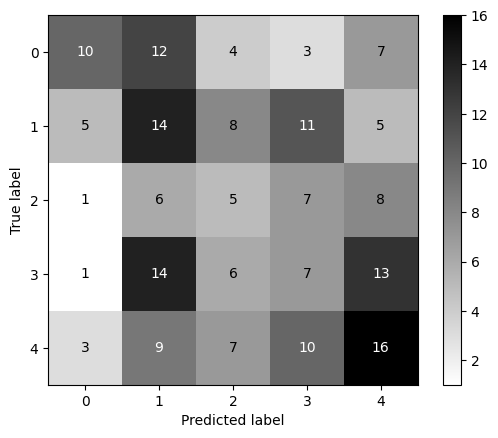

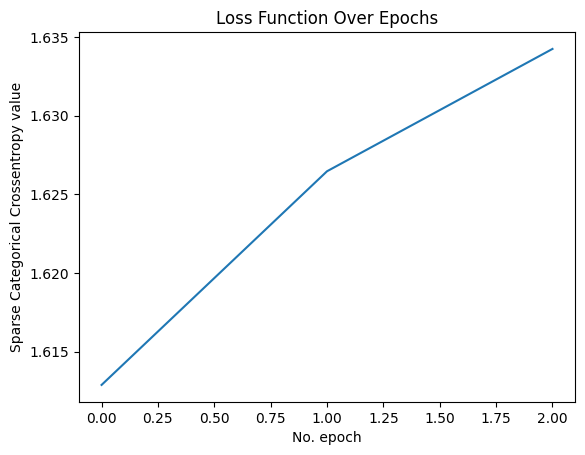

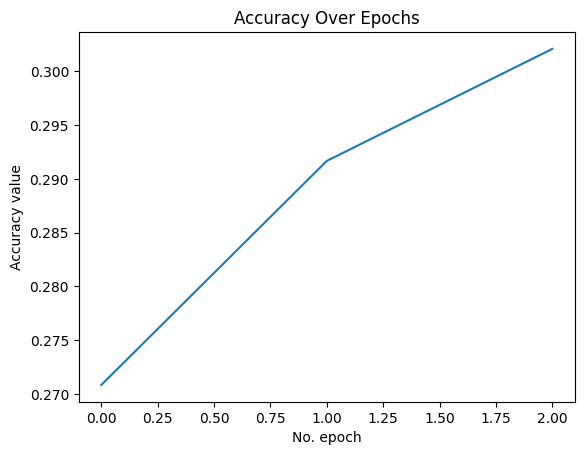

In [ ]:
best_poster_model = load_model(best_poster_model_checkpoint_path)
with open(f'{cfg.filename_prefix}best_standalone_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = PosterGenerator(
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_poster_model, test_generator, y_test, 'standalone', history=full_history)

In [ ]:
def train(
    model,
    train_generator,
    val_generator,
    class_weights,
    checkpoint_path,
    epochs=cfg.num_epochs,
):
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoardd
    tensorboard = TensorBoard(log_dir="./logs")

    # Обучение модели
    full_history = model.fit(
        x=train_generator,
        validation_data=val_generator,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1,
        callbacks=[
            checkpoint,
            early_stopping,
        ],
    )
    model.save(checkpoint_path)

    p = Path(checkpoint_path)
    with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
        dill.dump(full_history, f, protocol=5)

    return model, full_history

## Обучение отдельно

In [ ]:
best_poster_model = load_model(best_poster_model_checkpoint_path)

In [ ]:
best_poster_model.count_params()

13134147

### Интеграция на входном слое

In [ ]:
from keras.utils import plot_model

tabular_and_pretrained_poster_INPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='input',
        trainable=False
    ),
)
# plot_model(tabular_and_pretrained_poster_INPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [ ]:
from keras.optimizers import AdamW

train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=True,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)

optimizer = AdamW(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_INPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_pretrained_input_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_INPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

6_bor_poster_postreleased_efficientnet/best_pretrained_input_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step
Exact match accuracy: 0.21875
One class away accuracy: 0.4479166666666667
Precision per class: [0.19653179 0.         0.         0.         1.        ]
Recall per class: [0.94444444 0.         0.         0.         0.17777778]
F1 score per class [0.32535885 0.         0.         0.         0.30188679]
Macro Precision: 0.23930635838150288
Macro Recall: 0.22444444444444445
Macro F1: 0.12544912882549425
Micro Precision: 0.21875
Micro Recall: 0.21875
Micro F1: 0.21875


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


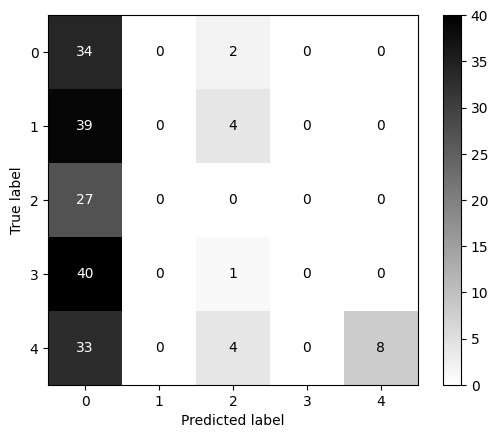

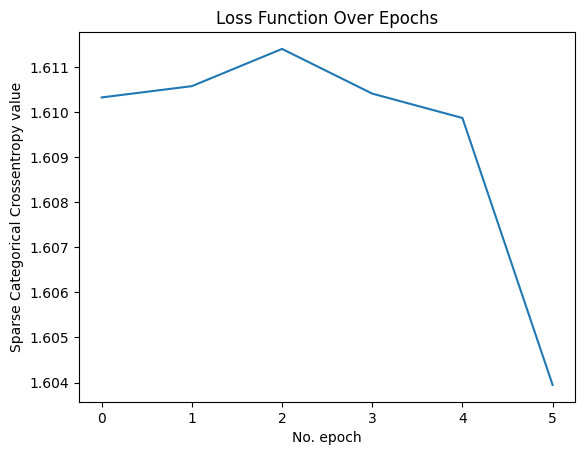

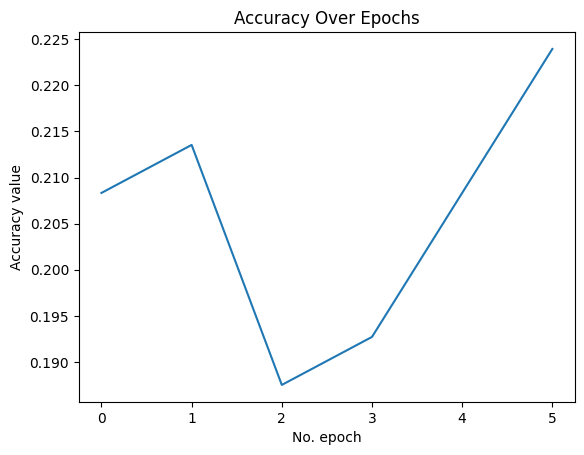

In [ ]:
best_model = load_model(checkpoint_path)
print(checkpoint_path)
with open(f'{cfg.filename_prefix}best_pretrained_input_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=full_history)

### Интеграция на промежуточном слое

In [ ]:
from keras.utils import plot_model

tabular_and_pretrained_poster_MIDDLE_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='middle',
        trainable=False
    ),
)
# plot_model(tabular_and_pretrained_poster_MIDDLE_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [ ]:
train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=True,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)

optimizer = AdamW(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_MIDDLE_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_pretrained_middle_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_MIDDLE_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

6_bor_poster_postreleased_efficientnet/best_pretrained_middle_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Exact match accuracy: 0.5416666666666666
One class away accuracy: 0.9375
Precision per class: [0.625      0.45454545 0.32692308 0.56521739 0.82926829]
Recall per class: [0.55555556 0.46511628 0.62962963 0.31707317 0.75555556]
F1 score per class [0.58823529 0.45977011 0.43037975 0.40625    0.79069767]
Macro Precision: 0.5601908430911612
Macro Recall: 0.5445860381084431
Macro F1: 0.5350665660628448
Micro Precision: 0.5416666666666666
Micro Recall: 0.5416666666666666
Micro F1: 0.5416666666666666


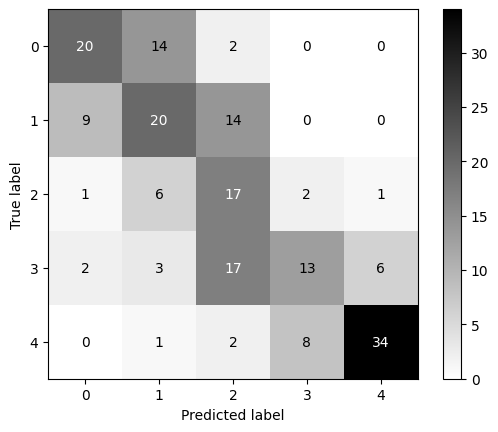

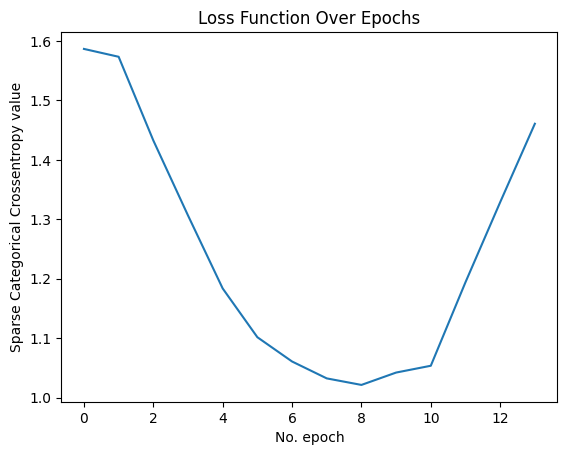

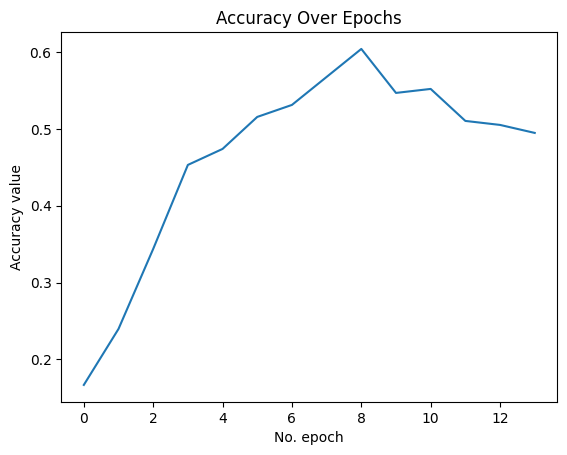

In [ ]:
best_model = load_model(checkpoint_path)
print(checkpoint_path)
with open(f'{cfg.filename_prefix}best_pretrained_middle_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=full_history)

### Интеграция на выходном слое

In [ ]:
from keras.utils import plot_model

tabular_and_pretrained_poster_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-1,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    additional_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last").output,
        port='output',
        trainable=False
    ),
)
tabular_and_pretrained_poster_OUTPUT_model.count_params()
# plot_model(tabular_and_pretrained_poster_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [ ]:
from keras.optimizers import AdamW

train_generator = TabularPosterGenerator(
    tabular=X_train.drop('poster', axis=1).values,
    posters=X_train['poster'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=True,
)
val_generator = TabularPosterGenerator(
    tabular=X_val.drop('poster', axis=1).values,
    posters=X_val['poster'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)

optimizer = AdamW(
    learning_rate=cfg.learning_rate,
)
tabular_and_pretrained_poster_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_pretrained_output_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=tabular_and_pretrained_poster_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

In [ ]:
tabular_and_pretrained_poster_OUTPUT_model.count_params()

13335352

6_bor_poster_postreleased_efficientnet/best_pretrained_output_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step
Exact match accuracy: 0.5729166666666666
One class away accuracy: 0.921875
Precision per class: [0.68       0.48       0.31111111 0.6        0.96875   ]
Recall per class: [0.47222222 0.55813953 0.51851852 0.58536585 0.68888889]
F1 score per class [0.55737705 0.51612903 0.38888889 0.59259259 0.80519481]
Macro Precision: 0.6079722222222222
Macro Recall: 0.5646270036343773
Macro F1: 0.5720364736229359
Micro Precision: 0.5729166666666666
Micro Recall: 0.5729166666666666
Micro F1: 0.5729166666666666


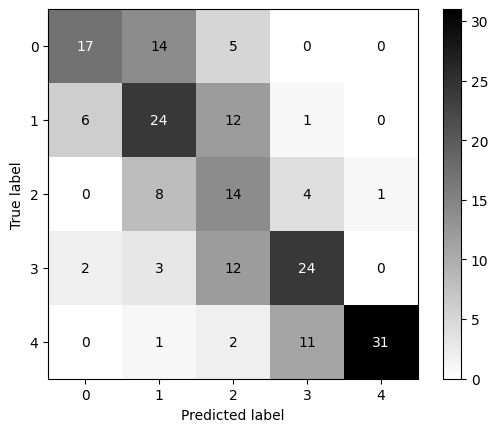

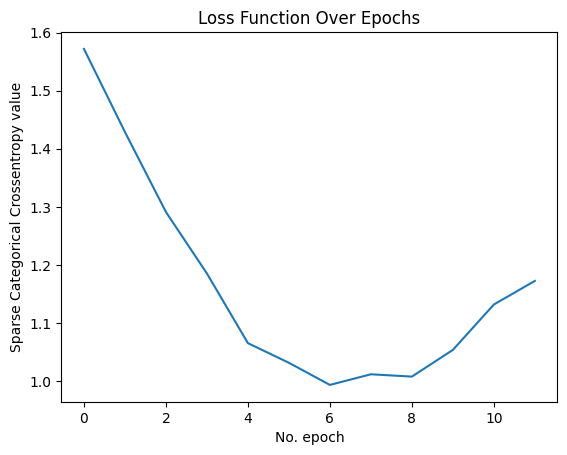

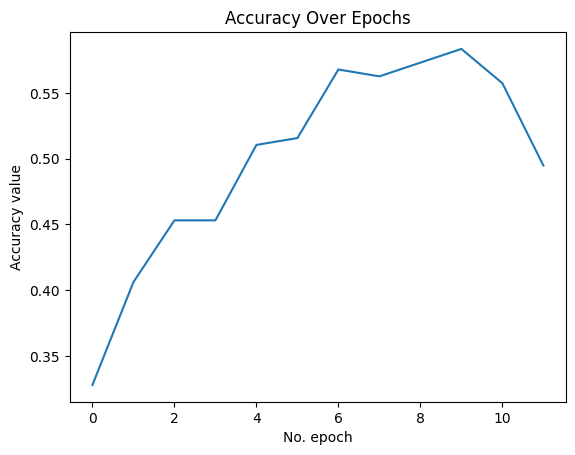

In [ ]:
best_model = load_model(checkpoint_path)
print(checkpoint_path)
with open(f'{cfg.filename_prefix}best_pretrained_output_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)

test_generator = TabularPosterGenerator(
    tabular=X_test.drop('poster', axis=1).values,
    posters=X_test['poster'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    dim=cfg.poster_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=full_history)

In [ ]:
def permutation_poster_feature_importance(model, X_test, y_test, num_iter=10):
    baseline_generator = TabularPosterGenerator(
        tabular=X_test.drop('poster', axis=1).values,
        posters=X_test['poster'].values,
        labels=y_test,
        batch_size=cfg.batch_size,
        dim=cfg.poster_shape,
        shuffle=False,
    )

    baseline = model.evaluate(baseline_generator)[1]

    importance = {
        'poster': []
    }

    for _ in range(num_iter):
        permutation_generator = TabularPosterGenerator(
            tabular=X_test.drop('poster', axis=1).values,
            posters=X_test['poster'].values,
            labels=y_test,
            batch_size=cfg.batch_size,
            dim=cfg.poster_shape,
            shuffle=False,
            shuffle_posters=True,
        )
        score = model.evaluate(permutation_generator)[1]
        importance['poster'].append(score / baseline)

    for k, v in importance.items():
        importance[k] = np.array(v)

    return importance

In [ ]:
importance = permutation_poster_feature_importance(best_model, X_test, y_test, num_iter=100)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5692 - loss: 1.2760
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5765 - loss: 1.3106
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5276 - loss: 1.3228
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5475 - loss: 1.3291
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5392 - loss: 1.3173
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5471 - loss: 1.3180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5901 - loss: 1.3577
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5589 - loss: 1.2984
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5685 - loss: 1.2910
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5565 - loss: 1.3144
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5772 - loss: 1.2963
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5580 - loss: 1.3064
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5693 - loss: 1.2776
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5494 - loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance(importance):
    data = {
        k: [np.percentile(v, 5), np.mean(v), np.percentile(v, 95)] for k, v in importance.items()
    }

    # Создание списка названий признаков и списков с минимальными и максимальными значениями важности
    features = list(data.keys())
    features.sort(key=lambda k: data[k][1], reverse=True)
    min_values = [data[feature][0] for feature in features]
    mean_values = [data[feature][1] for feature in features]
    max_values = [data[feature][2] for feature in features]

    # Создание графика
    fig, ax = plt.subplots()

    # Построение полосок для каждого признака
    for i, feature in enumerate(features):
        ax.plot([min_values[i], max_values[i]], [i, i], color='black', linewidth=3)
        ax.plot(mean_values[i], i, 'ko')

    # Настройка осей и заголовков
    ax.set_ylim(-1, len(features))  # Установка границ по оси Y
    ax.set_yticks(range(len(features)))  # Установка меток на оси Y
    ax.set_yticklabels(features)  # Назначение названий признаков на оси Y
    ax.set_xlabel("Важность признака")  # Заголовок оси X

    # Отображение графика
    plt.show()

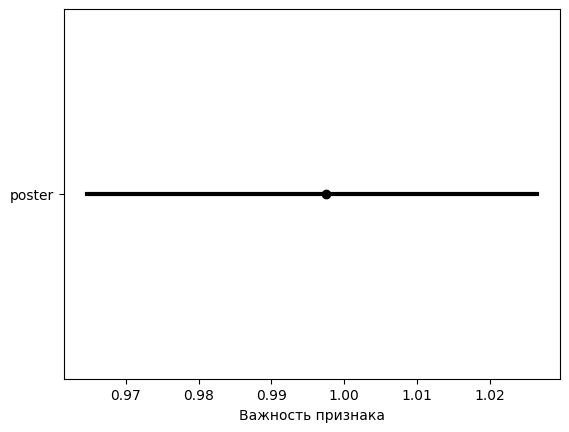

In [ ]:
plot_importance(importance)